In [2]:
base_path = "src/nodes"

In [3]:
node_name = "batch_qa"

In [4]:
node_folder = f"{base_path}/{node_name}"

# Config

In [8]:
import hypster
from hypster import HP

@hypster.config
def hp_config(hp: HP):
    from src.hypernodes import HyperNode
    queries_path = hp.text_input("data/qa.xlsx")
    texts_path = hp.text_input("data/raw")

    base_path = "src/nodes"
    
    rag_qa_node = HyperNode.load(f"{base_path}/rag_qa")
    rag_qa_node._instantiated_inputs = hp.propagate(rag_qa_node.hp_config, "rag_qa")
    
    from hamilton.plugins.h_mlflow import MLFlowTracker
    from hamilton.driver import Builder

    adapters = []
    if hp.select([True, False], name="use_mlflow_adapter", default=True):
        mlflow_tracking_uri = hp.text_input("file:./mlruns")
        mlflow_adapter = MLFlowTracker(tracking_uri=mlflow_tracking_uri)
        adapters.append(mlflow_adapter)
        
    builder = Builder().with_adapters(*adapters)

In [9]:
inputs, snp = hp_config(overrides={"rag_qa.llm_model" : "haiku", "rag_qa_node.top_k_pages.top_k" : 2}, return_config_snapshot=True)

In [10]:
inputs.update(snp)

In [11]:
globals().update(inputs)

# DAG

In [12]:
%load_ext hamilton.plugins.jupyter_magic

In [21]:
display_config = dict(output_file_path=f"{node_folder}/{node_name}_dag.png",
                      show_legend=False, orient="TB", hide_inputs=True)

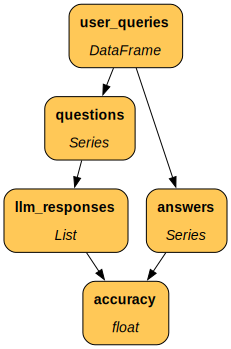

In [22]:
%%cell_to_module dag --display display_config --inputs inputs --hide_results --execute --builder builder

import pandas as pd
from typing import List
from src.hypernodes import HyperNode
from hamilton.function_modifiers import extract_columns

@extract_columns("questions", "answers")
def user_queries(queries_path: str) -> pd.DataFrame:
    return pd.read_excel(queries_path)

def llm_responses(questions: pd.Series, texts_path: str, rag_qa_node: HyperNode) -> List[str]:
    responses = []
    inputs = rag_qa_node._instantiated_inputs
    for question in questions:
        inputs.update({"user_query" : question, "texts_path" : texts_path})
        res = rag_qa_node.execute(final_vars=["llm_response"], inputs=inputs)
        responses.append(res["llm_response"])
    return responses

def accuracy(llm_responses: List[str], answers: pd.Series) -> float:
    correct = pd.Series(llm_responses).str.lower() == answers.astype(str).str.lower()
    return sum(correct) / len(correct)

In [15]:
accuracy

0.6

In [17]:
from src.hypernodes import HyperNode
node = HyperNode(name=node_name,
                   dag_modules=[dag], 
                   hp_config=hp_config)
node.save(folder=node_folder)

# HPO

In [18]:
import itertools
def get_combinations(dct):
    return [dict(zip(dct.keys(), combination)) for combination in itertools.product(*dct.values())]

In [19]:
#TODO: ask for options on demand

In [20]:
options = {"rag_qa.llm_model" : ["gpt-4o-latest", "haiku", "mini"],
          "raw_qa.top_k_chunks.ngram_range" : ["basic", "expanded"]}

In [16]:
for combination in get_combinations(options):
   node.instantiate_inputs(selections=combination, return_config_snapshot=True)
   results = node.execute(final_vars=["accuracy"], inputs=node._instantiated_inputs)